# Seleção de Atributos

## Colunas com alta correlação(colinares)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)

In [3]:
url = ("https://hbiostat.org/data/repo/titanic3.csv")
df = pd.read_csv(url)
orig_df = df

In [4]:
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
) ->(pd.DataFrame, pd.DataFrame, pd.Series, pd.Series):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()
    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(orig_df)
std_cols = "pclass,age,sibsp,fare".split(",")

X_train: pd.DataFrame
X_test: pd.DataFrame
y_train: pd.Series
y_test: pd.Series = get_train_test_X_y(ti_df, "survived", std_cols=std_cols)

X_train, X_test, y_train, y_test = get_train_test_X_y(ti_df, "survived", std_cols=std_cols)

X: pd.Series = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [5]:
ti_df['cabin'] = orig_df['cabin']

In [6]:
agg = (
     ti_df.groupby("cabin")
     .agg("min,max,mean,sum".split(","))
     .reset_index()
)
agg.columns = [
     "_".join(c).strip("_")
     for c in agg.columns.values
]
agg_df = ti_df.merge(agg, on="cabin")

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit_transform(agg_df['cabin'])
agg_df['cabin'] = le.transform(agg_df['cabin'])

In [8]:
limit = 0.95
corr = agg_df.corr()
mask = np.triu(
    np.ones(corr.shape), k=1
).astype(bool)
corr_no_diag = corr.where(mask)
coll = [
    c
    for c in corr_no_diag.columns
    if any(abs(corr_no_diag[c]) > limit)
]

In [9]:
coll

['pclass_min',
 'pclass_max',
 'pclass_mean',
 'sibsp_mean',
 'parch_mean',
 'fare_mean',
 'embarked_S_min',
 'embarked_S_max',
 'embarked_S_mean']

In [10]:
cols = ['age', 'fare']
ip = impute.IterativeImputer()
ip.fit_transform(ti_df[cols])
ti_df[cols] = ip.transform(ti_df[cols])
ti_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass      1309 non-null   int64  
 1   survived    1309 non-null   int64  
 2   age         1309 non-null   float64
 3   sibsp       1309 non-null   int64  
 4   parch       1309 non-null   int64  
 5   fare        1309 non-null   float64
 6   sex_male    1309 non-null   bool   
 7   embarked_Q  1309 non-null   bool   
 8   embarked_S  1309 non-null   bool   
 9   cabin       295 non-null    object 
dtypes: bool(3), float64(2), int64(4), object(1)
memory usage: 75.5+ KB


/home/pcmoraes/anaconda3/lib/python3.11/site-packages/rfpimp.py:52: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


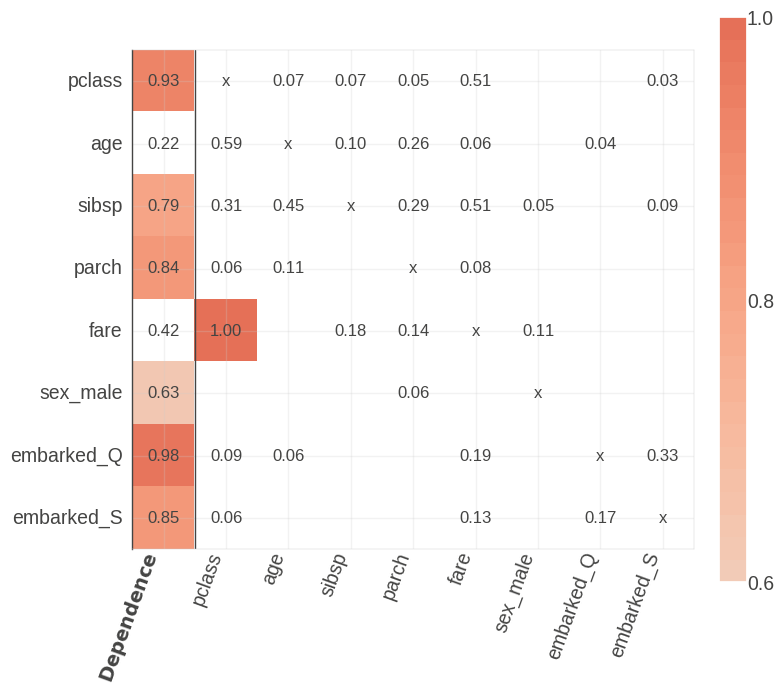

In [11]:
import rfpimp
rfpimp.plot_dependence_heatmap(
    rfpimp.feature_dependence_matrix(X_train),
    value_fontsize=12,
    label_fontsize=14,
    figsize=(8, 8)
)
fig = plt.gcf()

Foi encontrado uma grande correlação entre `fare` e `pclass`

In [12]:
cols_to_remove = [
    'pclass',
]

rf3 = ensemble.RandomForestClassifier(random_state=42)

rf3.fit(
    X_train[
        [
            c
            for c in X_train.columns
            if c not in cols_to_remove
        ]
    ],
    y_train,
)

RandomForestClassifier(random_state=42)

In [13]:
rf3.score(
    X_test[
        [
            c
            for c in X_test.columns
            if c not in cols_to_remove
        ]
    ],
    y_test,
)


0.8015267175572519

In [14]:
rf4 = ensemble.RandomForestClassifier(random_state=42)
rf4.fit(X_train, y_train)
rf4.score(X_test, y_test)

0.7938931297709924

Removendo uma das colunas com alta correlação `pclass` e executando o treinamento utilizando o `RandomForestClassifier` obteve-se uma acurácia de 0.8 aproximadamente. Fazendo o mesmo treinamento, mas utilizando as duas colunas com alta correlação, obteve-se uma acurácia de 0.79 aproximadamente.

## Regressão Lasso

In [15]:
from sklearn import linear_model

Text(0.5, 1.0, 'Regression Coefficients Progression for Lasso Paths')

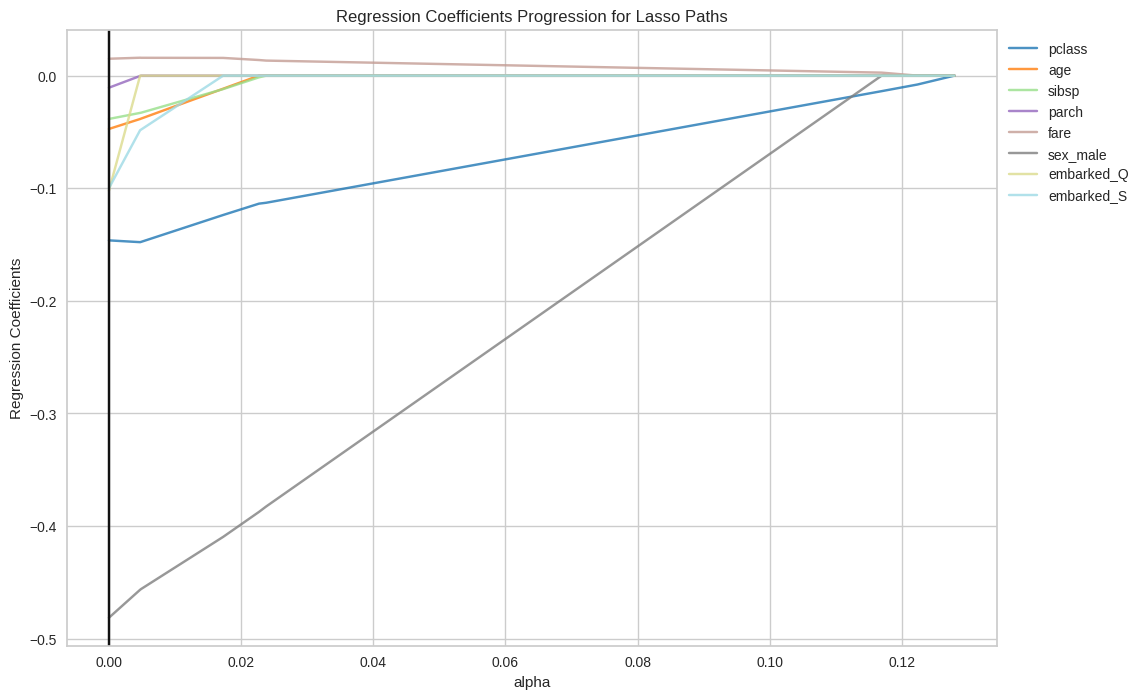

In [16]:
model = linear_model.LassoLarsCV(
    cv=10, max_n_alphas=10
).fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(12, 8))

cm = iter(
    plt.get_cmap("tab20")(
        np.linspace(0, 1, X.shape[1])
    )
)

for i in range(X.shape[1]):
    c = next(cm)
    ax.plot(
        model.alphas_,
        model.coef_path_.T[:, i],
        c=c,
        alpha=0.8,
        label=X.columns[i],
    )
ax.axvline(
    model.alpha_,
    linestyle="-",
    c="k",
    label="alphaCV",
)
plt.ylabel("Regression Coefficients")
ax.legend(X.columns, bbox_to_anchor=(1, 1))
plt.xlabel("alpha")
plt.title(
    "Regression Coefficients Progression for Lasso Paths"
)

## Eliminação Recursiva de Atributos

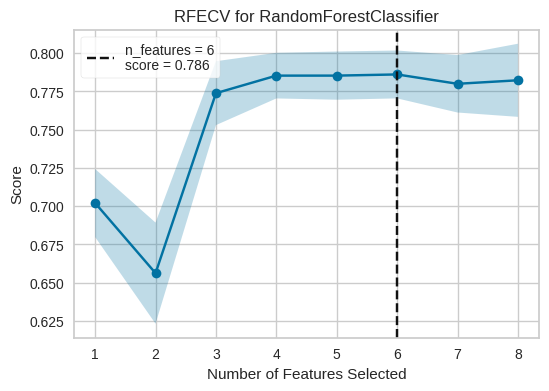

<Axes: title={'center': 'RFECV for RandomForestClassifier'}, xlabel='Number of Features Selected', ylabel='Score'>

In [17]:
from yellowbrick.features import RFECV
fig, ax = plt.subplots(figsize=(6, 4))
rfe = RFECV(
    ensemble.RandomForestClassifier(
        n_estimators=100
    ),
    cv=5,
)
rfe.fit(X, y)
rfe.rfe_estimator_.ranking_
rfe.rfe_estimator_.n_features_
rfe.rfe_estimator_.support_
rfe.poof()

In [18]:
from sklearn.feature_selection import RFE
model = ensemble.RandomForestClassifier(
    n_estimators=100
)
rfe = RFE(model)
rfe.fit(X, y)
X.columns[rfe.support_]

Index(['pclass', 'age', 'fare', 'sex_male'], dtype='object')

## Informação Mútuas

<Axes: ylabel='feature'>

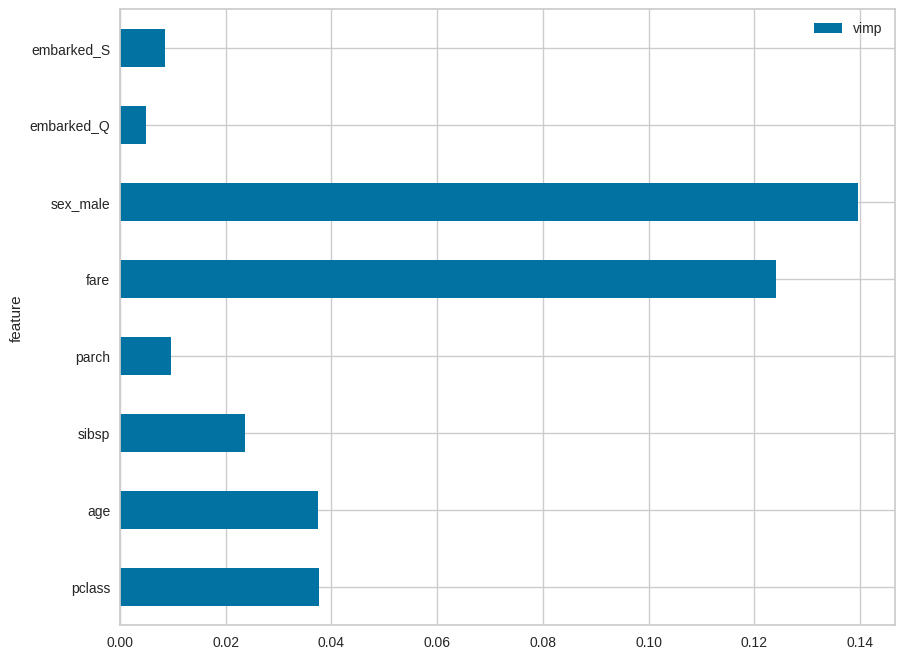

In [19]:
from sklearn import feature_selection
mic = feature_selection.mutual_info_classif(
    X, y
)
fig, ax = plt.subplots(figsize=(10, 8))
(
    pd.DataFrame(
        {"feature": X.columns, "vimp": mic}
    )
    .set_index("feature")
    .plot.barh(ax=ax)
)